# Tutorial 1 - Finding, Saving, and Loading Elevation Data for Your Study Area

This notebook demonstrates a simple workflow for obtaining elevation data (DEM) for a study area using a shapefile and the National Map 30m DEM.

## 1. Load Study Area Shapefile

We'll use `geopandas` to load the study area shapefile located at `data/Study_Area`.

<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\rl587\AppData\Local\Temp\ipykernel_35556\2557443310.py:4: SyntaxWarning: invalid escape sequence '\S'
  shapefile_path = "data\Study_Area.shp"


   Shape_Leng    Shape_Area                                           geometry
0  6961.57906  2.758734e+06  POLYGON Z ((-12426957.64 4188869.122 0, -12426...


<Axes: >

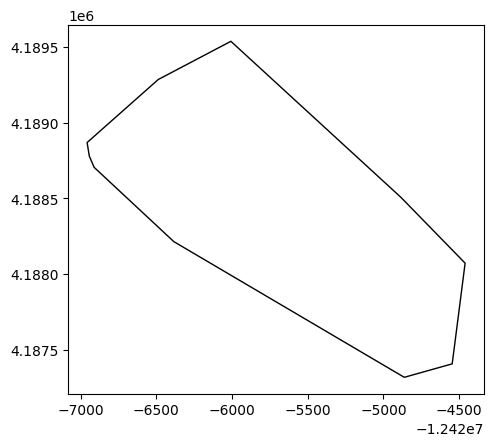

In [2]:
import geopandas as gpd

# Load the study area shapefile
shapefile_path = "data\Study_Area.shp"
gdf = gpd.read_file(shapefile_path)

# Display basic info
print(gdf)
gdf.plot(edgecolor='k', facecolor='none')

## 2. Find Elevation Data for Your Area

We'll use the National Map's Elevation Point Query Service to find a 30m DEM tile that covers our study area. For simplicity, we'll use the bounding box of the shapefile.

In [4]:
import requests

# Get bounding box of study area
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds

# National Map API endpoint for 3DEP 1 arc-second DEM (approx 30m)
search_url = (
    "https://tnmaccess.nationalmap.gov/api/v1/products?"
    f"bbox={minx},{miny},{maxx},{maxy}&datasets=3DEP_1"
)

response = requests.get(search_url)
data = response.json()

# Find the first available DEM download URL
dem_url = None
for item in data.get("items", []):
    for link in item.get("downloadLinks", []):
        if link.endswith(".tif"):
            dem_url = link
            break
    if dem_url:
        break

print("DEM download URL:", dem_url)

DEM download URL: None


## 3. Download Elevation Data

Download the DEM GeoTIFF file for the study area.

In [ ]:
import os

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)
dem_path = os.path.join(output_dir, "study_area_dem.tif")

if dem_url:
    dem_response = requests.get(dem_url, stream=True)
    with open(dem_path, "wb") as f:
        for chunk in dem_response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"DEM saved to {dem_path}")
else:
    print("DEM URL not found. Please check the API response.")

## 4. Save the DEM or TIFF

The DEM file has been saved as a GeoTIFF in the `data` folder.

## 5. Load and Display Elevation Data

We'll use `rasterio` and `matplotlib` to load and visualize the elevation data.

In [ ]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open(dem_path) as src:
    elevation = src.read(1)
    plt.figure(figsize=(8, 6))
    plt.imshow(elevation, cmap="terrain")
    plt.colorbar(label="Elevation (m)")
    plt.title("Elevation Data (DEM)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()